# Setup

## Libraries

In [215]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
sns.set_theme()

## CFG

In [3]:
class CFG:
    DATASET_PATH = './Dataset/'

## Chess Functions

Functions written for different tasks.

In [4]:
class ChessFunctions:
    def FirstTwoMoves(moves):
        splitted = moves.split(maxsplit=2)
        return splitted[0], splitted[1]
    
    def FormatIncrementCode(inc):
        splitted = inc.split('+')
        return int(splitted[0])
    
    def CategorizeTime(inc):
        if inc < 3:
            return 'bullet'
        elif inc < 9:
            return 'blitz'
        elif inc < 16:
            return 'rapid'
        else:
            return 'classical'

## Loading Dataset

In [5]:
games = pd.read_csv(CFG.DATASET_PATH + 'games.csv')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


We have no null values.

<hr>

# Preparing Dataset

## Dropping Columns

Some columns do not give much valuable information, so let's drop those.

In [6]:
cols_to_drop = ['id', 'created_at', 'last_move_at', 'white_id', 'black_id']
games = games.drop(columns=cols_to_drop)
games.head(5)

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
0,False,13,outoftime,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,True,16,resign,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,True,61,mate,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,True,61,mate,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,95,mate,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Dropping Very Short Games

Games with very short number of turns are not going to be meaningful at all. Let's drop those games which are less than 2 moves.

In [7]:
games = games.loc[games.turns > 2]
print('Number of games now: ', games.shape[0])
games.head(5)

Number of games now:  19855


,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
0,False,13,outoftime,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,True,16,resign,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,True,61,mate,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,True,61,mate,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,95,mate,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Only First Two Moves

There are many chess openings and analyzing each of them is a very lengthy task. So, I am limiting the analysis of chess openings upto first two moves only.

In [8]:
first_two_moves = np.vectorize(ChessFunctions.FirstTwoMoves)(games['moves'])
games['white_first_move'], games['black_first_move'] = first_two_moves[0], first_two_moves[1]

## Formatting Increment Code

The time format is written as "Starting Time (mostly in minutes) + Increment (in second)". Let's drop the incremental seconds and keep the starting time, as the starting time is a better indicator of format of the game (either, bullet, blitz, rapid or classical).

In [9]:
games['increment_code'] = np.vectorize(ChessFunctions.FormatIncrementCode)(games['increment_code'])
games['increment_code'].head(5)

0    15
1     5
2     5
3    20
4    30
Name: increment_code, dtype: int32

## Rating Difference

One more columns we can add is the rating difference between the players.

In [10]:
games['rating_difference'] = games['white_rating'] - games['black_rating']
games['rating_difference'].head(5)

0    309
1     61
2     -4
3    -15
4     54
Name: rating_difference, dtype: int64

## Categorize Format

<p>Just for some more simplicity and better visualizations, I am going to categorize the time format as follow: </p>
<ul>
    <li>Less than 3 minutes: Bullet</li>
    <li>Between 3 and 9: Blitz</li>
    <li>Between 9 and 16: Rapid</li>
    <li>More than 16 minutes: Classical</li>
</ul>
<p><b>Note:</b> The categorization of format is my own and not according to the 'standard'.</p> 

In [11]:
games['format'] = np.vectorize(ChessFunctions.CategorizeTime)(games['increment_code'])
games['format'].head(5)

0        rapid
1        blitz
2        blitz
3    classical
4    classical
Name: format, dtype: object

<hr>

# EDA

Let's start with simple plots first.

## Plots

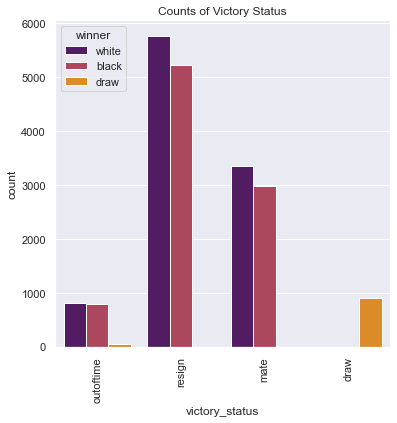

In [98]:
sns.set(rc={'figure.figsize':(6, 6)})
sns.countplot(data=games, x='victory_status', hue='winner', palette='inferno').set(title='Counts of Victory Status')
plt.xticks(rotation = 90)
plt.show()

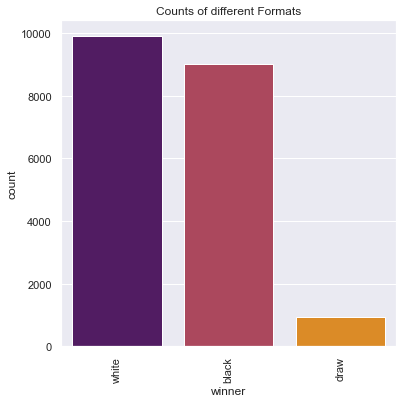

In [100]:
sns.set(rc={'figure.figsize':(6, 6)})
sns.countplot(data=games, x='winner', palette='inferno').set(title='Counts of different Formats')
plt.xticks(rotation = 90)
plt.show()

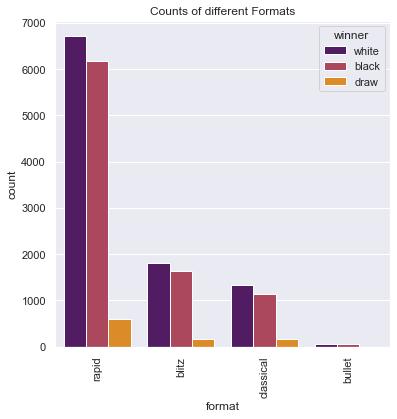

In [101]:
sns.set(rc={'figure.figsize':(6, 6)})
sns.countplot(data=games, x='format', hue='winner', palette='inferno').set(title='Counts of different Formats')
plt.xticks(rotation = 90)
plt.show()

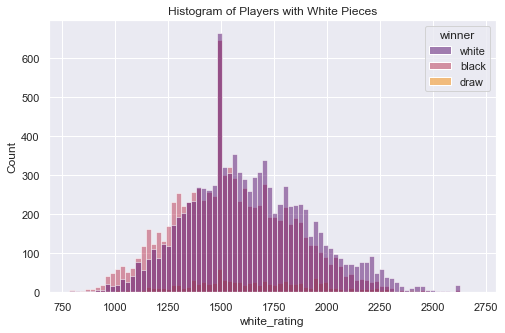

In [102]:
sns.set(rc={'figure.figsize':(8, 5)})
sns.histplot(data=games, x='white_rating', palette='inferno', hue='winner', bins=80).set(title='Histogram of Players with White Pieces')
plt.show()

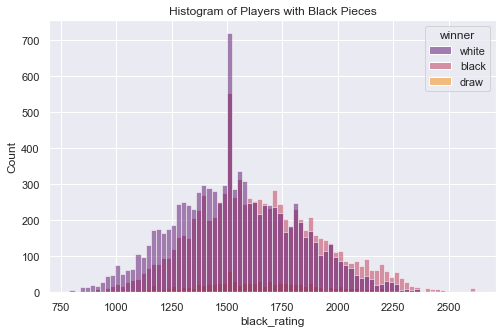

In [103]:
sns.set(rc={'figure.figsize':(8, 5)})
sns.histplot(data=games, x='black_rating', palette='inferno', hue='winner', bins=80).set(title='Histogram of Players with Black Pieces')
plt.show()

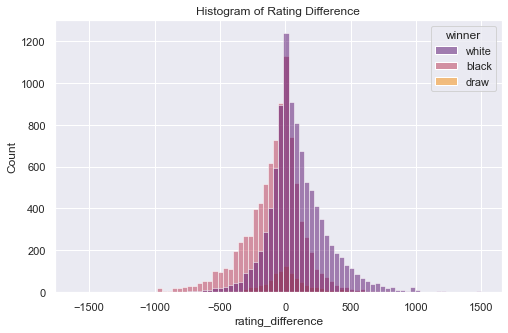

In [104]:
sns.set(rc={'figure.figsize':(8, 5)})
sns.histplot(data=games, x='rating_difference', hue='winner', palette='inferno', bins=80).set(title='Histogram of Rating Difference')
plt.show()

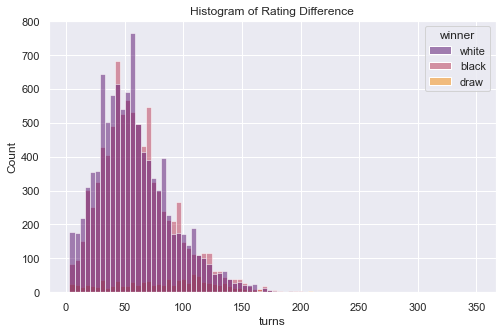

In [106]:
sns.histplot(data=games, x='turns', hue='winner', palette='inferno', bins=80).set(title='Histogram of Rating Difference')
sns.set(rc={'figure.figsize':(8, 5)})
plt.show()

In [21]:
print('Players with White Pieces of 1500 rating: ', games.white_rating.value_counts()[1500])
print('Players with Black Pieces of 1500 rating: ', games.black_rating.value_counts()[1500])

Players with White Pieces of 1500 rating:  799
Players with Black Pieces of 1500 rating:  787


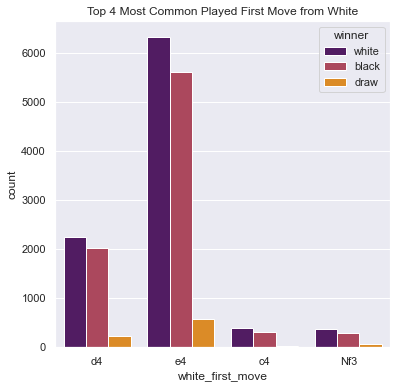

In [90]:
temp_dict = dict(games.white_first_move.value_counts(ascending=False)[0:4])
top_first_moves_white = list(temp_dict.keys())
temp_df = games[games.white_first_move.isin(top_first_moves_white)]

sns.countplot(data=temp_df, x='white_first_move', palette='inferno', hue='winner').set(title='Top 4 Most Common Played First Move from White')
plt.show()

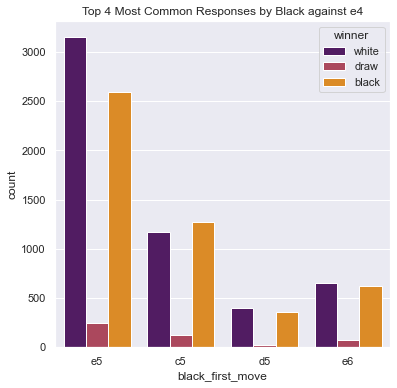

In [91]:
temp_df = temp_df.loc[temp_df.white_first_move == 'e4']
temp_dict = dict(temp_df.black_first_move.value_counts(ascending=False)[0:4])
top_black_moves_against_e4 = list(temp_dict.keys())
temp_df = temp_df[temp_df.black_first_move.isin(top_black_moves_against_e4)]

sns.countplot(data=temp_df, x='black_first_move', palette='inferno', hue='winner').set(title='Top 4 Most Common Responses by Black against e4')
plt.show()

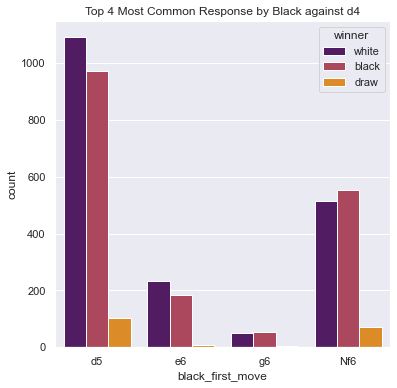

In [88]:
temp_df = games.loc[games.white_first_move == 'd4']
temp_dict = dict(temp_df.black_first_move.value_counts(ascending=False)[0:4])
top_black_moves_against_d4 = list(temp_dict.keys())
temp_df = temp_df[temp_df.black_first_move.isin(top_black_moves_against_d4)]

sns.countplot(data=temp_df, x='black_first_move', palette='inferno', hue='winner').set(title='Top 4 Most Common Response by Black against d4')
plt.show()

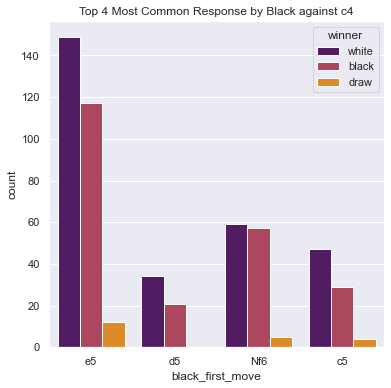

In [87]:
temp_df = games.loc[games.white_first_move == 'c4']
temp_dict = dict(temp_df.black_first_move.value_counts(ascending=False)[0:4])
top_black_moves_against_d4 = list(temp_dict.keys())
temp_df = temp_df[temp_df.black_first_move.isin(top_black_moves_against_d4)]

sns.countplot(data=temp_df, x='black_first_move', palette='inferno', hue='winner').set(title='Top 4 Most Common Response by Black against c4')
plt.show()

## Insights

<ul>
    <h3>General</h3>
    <li>Players with White Pieces had slightly more wins than the players with black pieces.</li>
    <li>Most of the games ended in resignation.</li>
    <li>The most played time format is Rapid (the 10-minute game format was most common).</li>
    <li>Most the rating of players lie around 1400 to 1600 (the most common rating is 1500 for both colors).</li>
    <li>The rating difference is good indicator to see which color has won. For a good machine learning model, it is a good idea to remove those games that have a very huge rating as many games do no have this much of a rating difference.</li>
    <li>Most games ended in 40-60 moves. </li>
    <h3>Openings</h3>
    <h5>e4</h5>
    <li>Most common first move is e4 by white, with d4 being the second most played.</li>
    <li>Against e4, most played moves by black were e5 (Open Game), c5 (Sicilian Defense), d5 (Scandinavian Defense) and e6 (French Defense).</li>
    <li>Out of the common defenses from black, Sicilian Defense (e4-c5) have slightly better score.</li>
     <h5>d4</h5>
    <li>Against d4, most played moves by black were d5 (Closed Game), Nf6 (Indian Game), e6 (Horwitz Defense) and g6 (Modern Defense).</li>
    <li>Out of the common defenses from black against d4, Indian Game (d4-Nf6) have slightly better winning rate.</li>
</ul>

<hr>

# Heatmaps

The idea of heatmaps is to make a 8x8 board to make a heatmap based on how much contested a specific square was.

## Preparation

In [327]:
PIECE = 'rook'

def squares_dictionary_maker():
    dictionary = {}
    for i in range(8):
        for j in range(8):
            square = chr(97+i) + str(j+1)
            dictionary[square] = 0

    return dictionary

def board_heatmap(moves):
    sq_dict = squares_dictionary_maker()
    moves = moves.split(' ')
    moves = [move for move in moves if move.endswith('.') == False]

    for move in moves:
        if move.startswith('O-'):
            if move == 'O-O':
                index = moves.index(move)
                if index%2 == 0:
                    sq_dict['f1'] = sq_dict['f1'] + 1
                    sq_dict['g1'] = sq_dict['g1'] + 1
                else:
                    sq_dict['f8'] = sq_dict['f8'] + 1
                    sq_dict['g8'] = sq_dict['g8'] + 1
                moves[index] = ''
            elif move == 'O-O-O':
                index = moves.index(move)
                if index%2 == 0:
                    sq_dict['d1'] = sq_dict['d1'] + 1
                    sq_dict['c1'] = sq_dict['c1'] + 1
                else:
                    sq_dict['d8'] = sq_dict['d8'] + 1
                    sq_dict['c8'] = sq_dict['c8'] + 1
                moves[index] = ''
        elif move.endswith('+') or move.endswith('#'):
            if str(move[-3]) == '=':
                sq_dict[str(move[-5:-3])] = sq_dict[str(move[-5:-3])] + 1
            else:
                sq_dict[str(move[-3:-1])] = sq_dict[str(move[-3:-1])] + 1
        elif move.endswith('Q') or move.endswith('N') or move.endswith('B') or move.endswith('R'):
            sq_dict[str(move[-4:-2])] = sq_dict[str(move[-4:-2])] + 1
        elif move == '':
            continue
        else:
            sq_dict[str(move[-2:])] = sq_dict[str(move[-2:])] + 1
            
    return sq_dict

def dict_formatter(sq_dict):
    square_values = np.array(list(sq_dict.values())) 
    square_values = square_values.reshape(8, 8)
    sq_T = square_values.T
    sq_T = np.flip(sq_T, 0)
    return sq_T

def make_heatmap_dataframe(table):
    heatmap_frame = pd.DataFrame(table)
    heatmap_frame.index = ['8', '7', '6', '5', '4', '3', '2', '1']
    heatmap_frame.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    return heatmap_frame

def plot_heatmap(frame, title, annot, ax=None, fontsize=20):
    if ax == None:
        plot = sns.heatmap(frame, annot = annot, cmap='inferno')
    else:
        plot = sns.heatmap(frame, annot = annot, cmap='inferno', ax=ax)
    plot.axes.set_title(title, fontsize=fontsize)
    return plot

def piece_heatmap(moves):
    moves = moves.split(' ')
    if PIECE == 'knight':
        moves = [move for move in moves if (move.startswith('N') == True)]
    elif PIECE == 'bishop':
        moves = [move for move in moves if (move.startswith('B') == True)]
    elif PIECE == 'rook':
        moves = [move for move in moves if (move.startswith('R') == True)]
    elif PIECE == 'king':
        moves = [move for move in moves if (move.startswith('K') == True)]
    elif PIECE == 'queen':
        moves = [move for move in moves if (move.startswith('Q') == True)]
    moves = ' '.join(moves)
    x = board_heatmap(moves)
    return x

def sum_all_heatmaps(heatmaps):
    summed = Counter(squares_dictionary_maker())
    for h in heatmaps:
        summed = summed + Counter(h)
        
    summed = dict(sorted(summed.items()))
    return summed

## Lots and Lots of Heatmaps

### Piece Heatmaps

Below, we are making heatmaps of different pieces (knight, bishop, queen, rook and king).

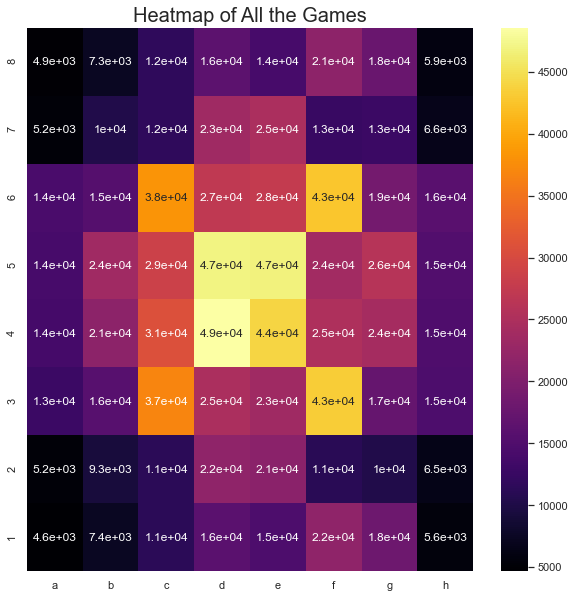

In [328]:
PIECE = ''
ANNOT = True

all_heatmaps = np.vectorize(piece_heatmap)(games['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

sns.set(rc={'figure.figsize':(10, 10)})
plot_heatmap(all_heatmaps, 'Heatmap of All the Games', ANNOT)
plt.show()

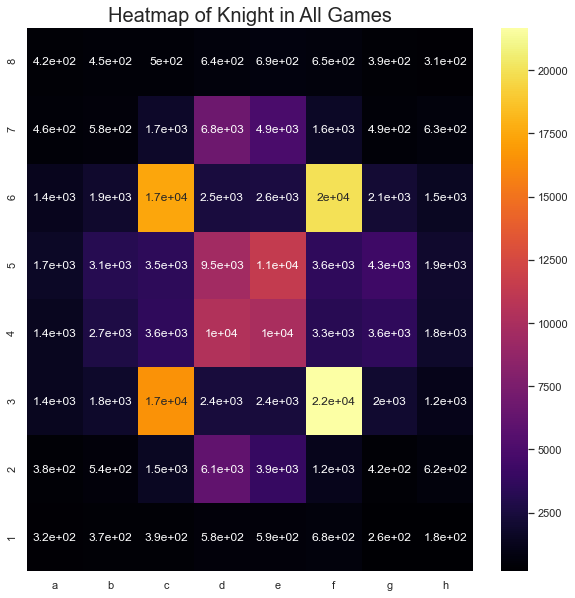

In [329]:
PIECE = 'knight'

all_heatmaps = np.vectorize(piece_heatmap)(games['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

sns.set(rc={'figure.figsize':(10, 10)})
plot_heatmap(all_heatmaps, 'Heatmap of Knight in All Games', ANNOT)
plt.show()

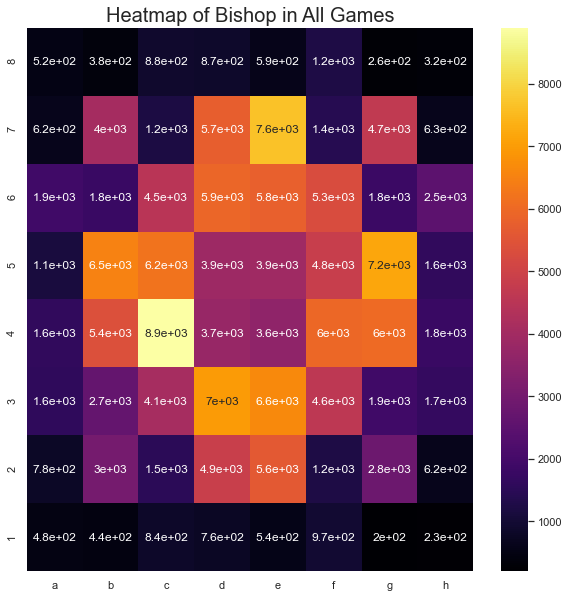

In [330]:
PIECE = 'bishop'

all_heatmaps = np.vectorize(piece_heatmap)(games['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

sns.set(rc={'figure.figsize':(10, 10)})
plot_heatmap(all_heatmaps, 'Heatmap of Bishop in All Games', ANNOT)
plt.show()

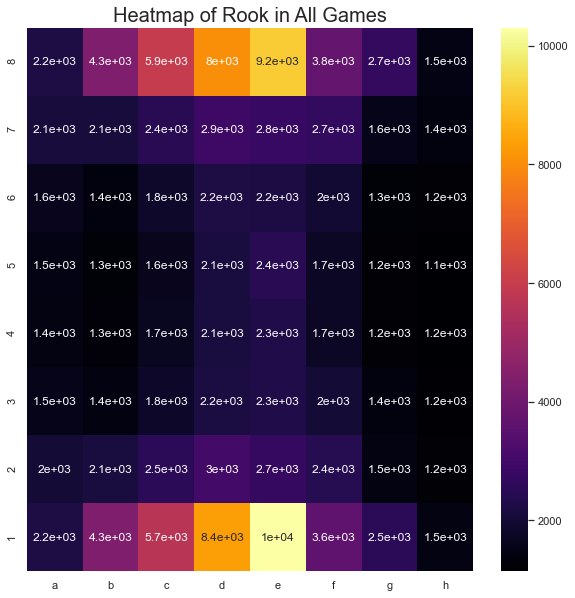

In [331]:
PIECE = 'rook'

all_heatmaps = np.vectorize(piece_heatmap)(games['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

sns.set(rc={'figure.figsize':(10, 10)})
plot_heatmap(all_heatmaps, 'Heatmap of Rook in All Games', ANNOT)
plt.show()

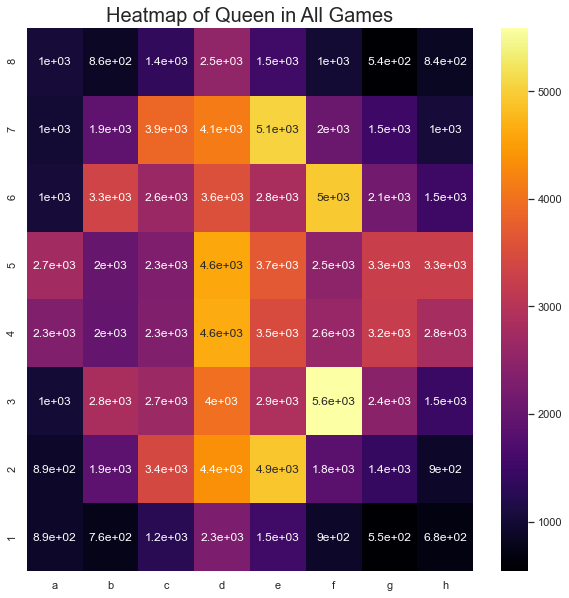

In [332]:
PIECE = 'queen'

all_heatmaps = np.vectorize(piece_heatmap)(games['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

sns.set(rc={'figure.figsize':(10, 10)})
plot_heatmap(all_heatmaps, 'Heatmap of Queen in All Games', ANNOT)
plt.show()

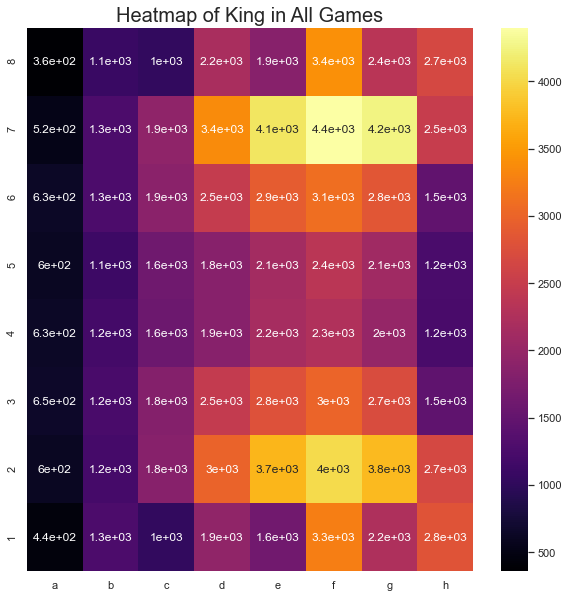

In [333]:
PIECE = 'king'

all_heatmaps = np.vectorize(piece_heatmap)(games['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

sns.set(rc={'figure.figsize':(10, 10)})
plot_heatmap(all_heatmaps, 'Heatmap of King in All Games', ANNOT)
plt.show()

### Insights

<ul>
    <li>The focus in most of the games is in the center of the board where e4, e5, d4 and d5 are the most contested squares.</li>
    <li>Knights' heatmap mainly shows that they are placed on their development squares most the time (f3, c3, f6, c6).</li>
    <li>The major squares for Bishops are c4 (which shows that Italian Game is very common) and b4, b5, g4, g5 (to pin the knight which is developed on f3, f6, c3, c6). </li>
    <li>Rooks are largely placed in the bottom rows and act as pillars and the heatmaps suggest the same.</li>
    <li>Queens' heatmap all over the board but still, the center squares are mainly contested by Queens.</li>
    <li>Kings' heatmap are focused on the right side of board which shows that Kingside Castling is way more common.</li>
</ul>

## Openings

Now, let's check heatmaps of different openings and see if they look different.

### e4

In [335]:
ANNOT = False
PIECE = ''

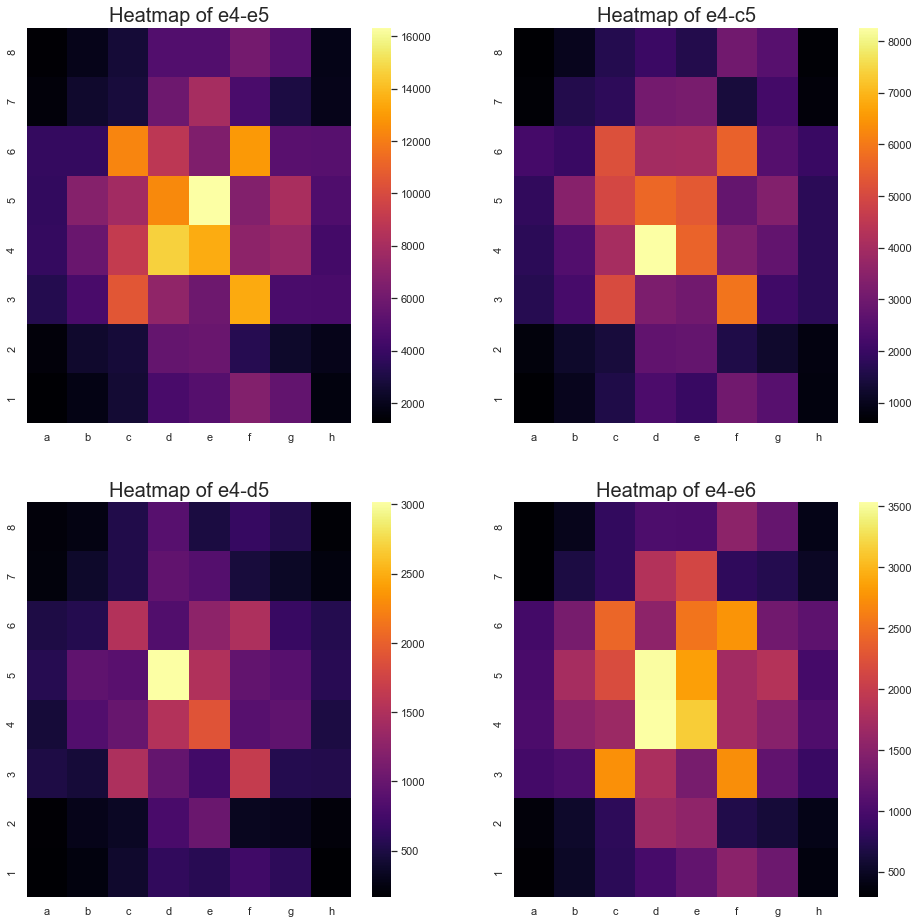

In [346]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'e4') & (games.black_first_move == 'e5')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of e4-e5', ANNOT, axs[0, 0])

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'e4') & (games.black_first_move == 'c5')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of e4-c5', ANNOT, axs[0, 1])

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'e4') & (games.black_first_move == 'd5')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of e4-d5', ANNOT, axs[1, 0])

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'e4') & (games.black_first_move == 'e6')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of e4-e6', ANNOT, axs[1, 1])
plt.show()

#### Insight

We are starting to see a little bit of theme here. It seems like for a specific opening, certain squares are more highly contested. For example, for Sicilian Defense (e4-c5) the d4 square is important, for Scandinavian Defense (e4-d5), the d5 square is very important and so on.

### d4

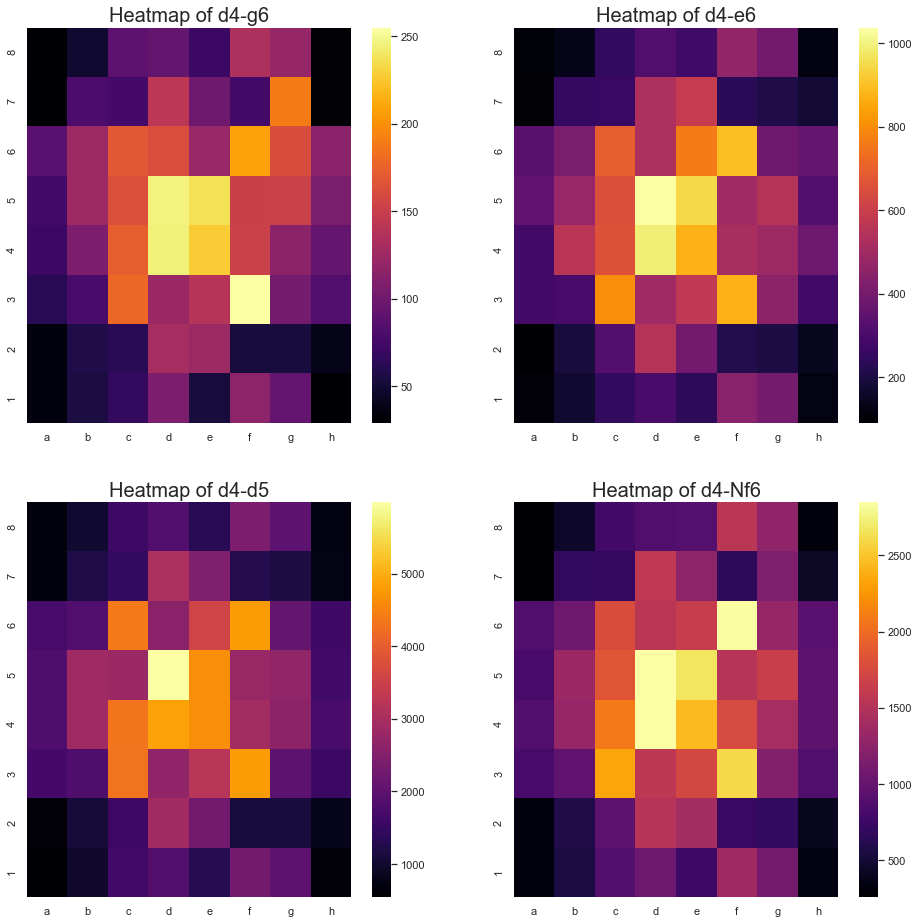

In [347]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'd4') & (games.black_first_move == 'g6')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of d4-g6', ANNOT, axs[0, 0])

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'd4') & (games.black_first_move == 'e6')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of d4-e6', ANNOT, axs[0, 1])

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'd4') & (games.black_first_move == 'd5')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of d4-d5', ANNOT, axs[1, 0])

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'd4') & (games.black_first_move == 'Nf6')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of d4-Nf6', ANNOT, axs[1, 1])
plt.show()

#### Insight

Compared to e4 openings, the themes are somewhat ambiguous. The main reason can be: The d4 openings usually result in Closed Games and the openings usually transpose into one another, so the games look somewhat similar. If we want to see clearer themes, the best way to do will be to go more moves deeper and further and then plot their heatmaps.

### c4

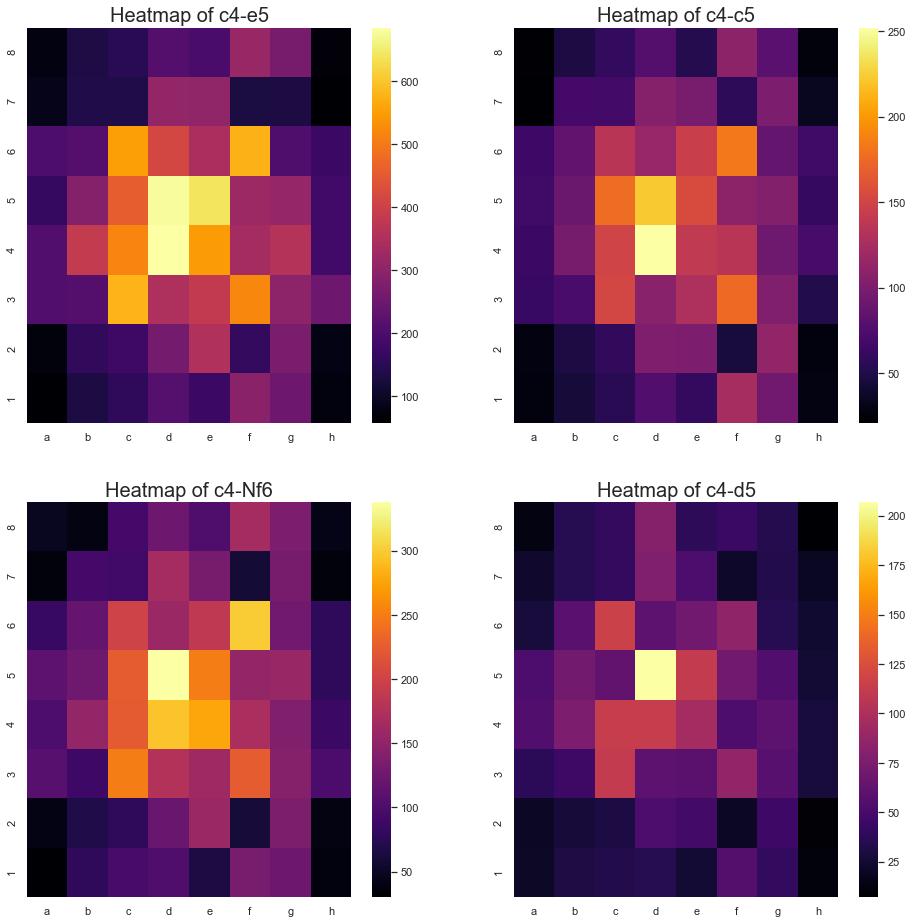

In [348]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'c4') & (games.black_first_move == 'e5')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of c4-e5', ANNOT, axs[0, 0])

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'c4') & (games.black_first_move == 'c5')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of c4-c5', ANNOT, axs[0, 1])

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'c4') & (games.black_first_move == 'Nf6')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of c4-Nf6', ANNOT, axs[1, 0])

all_heatmaps = np.vectorize(piece_heatmap)(games.loc[(games.white_first_move == 'c4') & (games.black_first_move == 'd5')]['moves'])
all_heatmaps = dict(sum_all_heatmaps(all_heatmaps))

all_heatmaps = dict_formatter(all_heatmaps)
all_heatmaps = make_heatmap_dataframe(all_heatmaps)

plot_heatmap(all_heatmaps, 'Heatmap of c4-d5', ANNOT, axs[1, 1])
plt.show()

We can go on and on and create more beautiful heatmaps and see what is going on in games, but I am going to stop here :)

<hr>

# Summary

<p>In summary, we did a lot of work in the notebooks and came with some interesting analysis. The plots can be really interesting for players who enjoy chess a lot. We visualized the numeric part of data. We checked the most common played openings. But the focus was to show beautiful heatmaps of games.</p>
<p>We can carry on and make even more plots and answer more interesting questions like what do games look like in different time formats? Can we see heatmaps of even more openings? What do games look like at different skill levels? And the list goes on. In future, we can build a model around the datasets as well.</p>

<hr>